In [ ]:
import datetime as dt
import os
import warnings
from collections import UserDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import TimeSeriesTensor, mape, extract_data, create_evaluation_df
from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [ ]:
!git clone https://github.com/Arghyam-Team/KRSPrediction.git

Cloning into 'KRSPrediction'...
remote: Enumerating objects: 236, done.
remote: Counting objects: 100% (236/236), done.
remote: Compressing objects: 100% (179/179), done.
remote: Total 236 (delta 98), reused 112 (delta 33), pack-reused 0
Receiving objects: 100% (236/236), 4.94 MiB | 8.98 MiB/s, done.
Resolving deltas: 100% (98/98), done.


In [ ]:
import sqlite3
db_file = '/content/KRSPrediction/data/pythonsqlite.db'
conn = sqlite3.connect(db_file)
cur = conn.cursor()
sql = "SELECT water.date, water.storage_tmc, water.inflow_cusecs, water.outflow_cusecs, weather.max_temp, weather.visibility, weather.wind, weather.humidity, weather.cloudcover FROM water INNER JOIN weather ON  water.reservoir='krs' AND weather.location='karnataka' AND water.date = weather.date"
cur.execute(sql)
rows = cur.fetchall() # rows is a list of tuples (date, tmc,inflow,outflow,maxtemp,vis,wind,hum,cloud)

In [ ]:
krs = pd.DataFrame(rows, columns=['date', 'present_storage_tmc', 'inflow', 'outflow', 'max_temp', 'visibility', 'wind', 'humidity', 'cloudcover'])

In [ ]:
krs.head(2)

,date,present_storage_tmc,inflow,outflow,max_temp,visibility,wind,humidity,cloudcover
0,2011-01-01,46.42,2029,2000.0,28.1,6.7,11.2,71.39,36.7
1,2011-01-02,46.54,3084,1490.0,28.0,6.2,10.3,72.90,51.4


In [ ]:
krs = krs.drop_duplicates(subset=["date"])

In [ ]:
krs.date = pd.to_datetime(krs.date)
krs['inflow'] = pd.to_numeric(krs.inflow, errors='coerce')

In [ ]:
krs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3531 entries, 0 to 3535
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 3531 non-null   datetime64[ns]
 1   present_storage_tmc  3531 non-null   float64       
 2   inflow               3530 non-null   float64       
 3   outflow              3531 non-null   float64       
 4   max_temp             3531 non-null   float64       
 5   visibility           3531 non-null   float64       
 6   wind                 3531 non-null   float64       
 7   humidity             3531 non-null   float64       
 8   cloudcover           3531 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 275.9 KB


In [ ]:
krs['inflow_tmc'] = krs['inflow'] /11000
krs['outflow_tmc'] = krs['outflow'] / 11000

In [ ]:
krs.sort_values(by=['date'], inplace=True, ascending=True)

In [ ]:
krs.set_index('date', inplace=True)
krs = krs.sort_index(axis=1)

In [ ]:
krs.head(2)

,cloudcover,humidity,inflow,inflow_tmc,max_temp,outflow,outflow_tmc,present_storage_tmc,visibility,wind
date,,,,,,,,,,
2010-09-30,79.6,81.05,2706.0,0.246000,29.4,6840.0,0.621818,46.18,5.2,11.2
2010-12-31,51.0,70.80,2668.0,0.242545,27.5,6795.0,0.617727,45.81,6.9,11.2


In [ ]:
#time series data on which model needs to be trained on, features contain the column names
ts_data_load = krs[[ "present_storage_tmc", "inflow_tmc", "outflow_tmc", "max_temp", "visibility", "humidity", "wind"]]
ts_data_load.sort_index(axis = 1)
features = len(ts_data_load.columns)
#features, ts_data_load.head(2), ts_data_load.tail(2)

In [ ]:
valid_st_data_load = "2018-01-01 00:00:00"
test_st_data_load = "2019-05-02 00:00:00"

In [ ]:
ts_data_load[ts_data_load.index==valid_st_data_load]

,present_storage_tmc,inflow_tmc,outflow_tmc,max_temp,visibility,humidity,wind
date,,,,,,,
2018-01-01,25.55,0.026455,0.313182,28.0,6.6,65.5,11.0


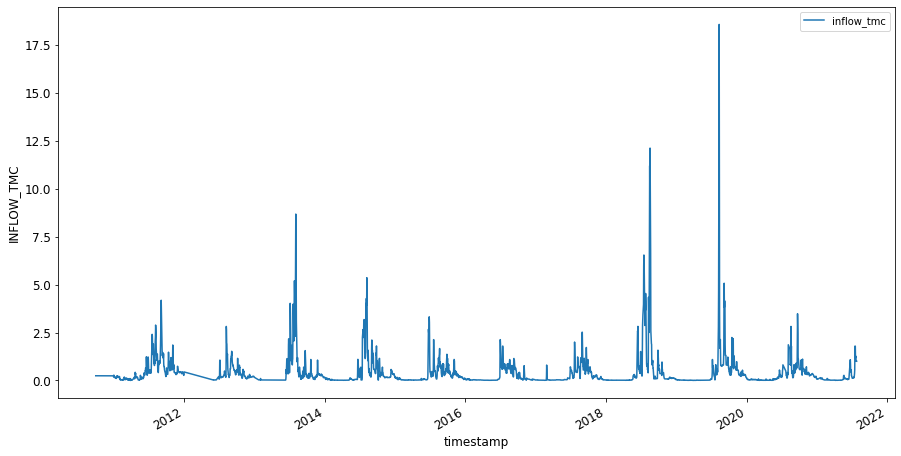

In [ ]:
ts_data_load[['inflow_tmc']].plot(figsize=(15, 8), fontsize=12)

plt.xlabel("timestamp", fontsize=12)
plt.ylabel("INFLOW_TMC", fontsize=12)
plt.show()

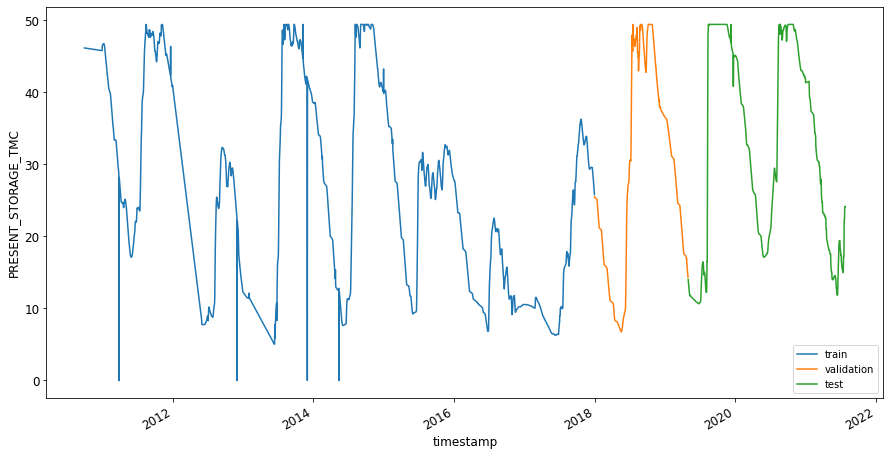

In [ ]:
ts_data_load[ts_data_load.index < valid_st_data_load][["present_storage_tmc"]].rename(columns={"present_storage_tmc": "train"}).join(
    ts_data_load[(ts_data_load.index >= valid_st_data_load) & (ts_data_load.index < test_st_data_load)][
        ["present_storage_tmc"]
    ].rename(columns={"present_storage_tmc": "validation"}),
    how="outer",
).join(
    ts_data_load[test_st_data_load:][["present_storage_tmc"]].rename(columns={"present_storage_tmc": "test"}), how="outer"
).plot(
    y=["train", "validation", "test"], figsize=(15, 8), fontsize=12
)
plt.xlabel("timestamp", fontsize=12)
plt.ylabel("PRESENT_STORAGE_TMC", fontsize=12)
plt.show()

In [ ]:
train = ts_data_load.copy()[ts_data_load.index < valid_st_data_load]

In [ ]:
train.shape

(2250, 7)

In [ ]:
y_scaler = MinMaxScaler()
y_scaler.fit(train[["present_storage_tmc"]])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
flist = list(ts_data_load.columns)

In [ ]:
T = 30
HORIZON = 1
train = ts_data_load.copy()[ts_data_load.index < valid_st_data_load][flist]

X_scaler = MinMaxScaler()
train[flist] = X_scaler.fit_transform(train)
train.sample(10)

,present_storage_tmc,inflow_tmc,outflow_tmc,max_temp,visibility,humidity,wind
date,,,,,,,
2014-09-14,1.000000,0.066879,0.062617,0.556075,0.800000,0.645138,0.127820
2017-11-29,0.624267,0.008707,0.051230,0.369159,0.483333,0.608670,0.103213
2012-10-08,0.549444,0.066083,0.125691,0.443925,0.616667,0.715876,0.064252
2013-12-21,0.806269,0.027231,0.026091,0.509346,0.550000,0.512302,0.039645
2014-08-25,0.972700,0.047873,0.062049,0.602804,0.783333,0.664470,0.140123
2015-03-17,0.523964,0.003531,0.040582,0.789720,0.850000,0.151142,0.076555
2011-11-05,0.995551,0.188011,0.194575,0.299065,0.350000,0.870533,0.095694
2011-11-13,0.985642,0.048051,0.070598,0.415888,0.650000,0.524165,0.027341
2015-12-14,0.623256,0.018105,0.048664,0.439252,0.433333,0.725688,0.085441


In [ ]:
train = train.dropna(axis = 0, how ='any')
train.isna().sum()

present_storage_tmc    0
inflow_tmc             0
outflow_tmc            0
max_temp               0
visibility             0
humidity               0
wind                   0
dtype: int64

In [ ]:
tensor_structure = {"X": (range(-T + 1, 1), flist)}
print(tensor_structure)
ts_train_inp = TimeSeriesTensor(
    dataset=train,
    target="present_storage_tmc",
    H=HORIZON,
    tensor_structure=tensor_structure,
    freq="D",
    drop_incomplete=True,
)
back_ts_data = dt.datetime.strptime(valid_st_data_load, "%Y-%m-%d %H:%M:%S") - dt.timedelta(
    days=T - 1
)
valid = ts_data_load.copy()[(ts_data_load.index >= back_ts_data) & (ts_data_load.index < test_st_data_load)][
    flist
]
valid[flist] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, "present_storage_tmc", HORIZON, tensor_structure, freq='D')

{'X': (range(-29, 1), ['present_storage_tmc', 'inflow_tmc', 'outflow_tmc', 'max_temp', 'visibility', 'humidity', 'wind'])}


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.models import Model, Sequential

In [ ]:
LATENT_DIM = T
BATCH_SIZE = 32
EPOCHS = (
    100
)

In [ ]:
model = Sequential()
model.add(GRU(LATENT_DIM, return_sequences=True,input_shape=(T, features)))
#model.add(GRU(LATENT_DIM, input_shape=(T, 3)))
model.add(GRU(LATENT_DIM))
model.add(Dense(HORIZON))

In [ ]:
model.compile(optimizer="adam", loss="mse")


In [ ]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 30, 30)            3510      
_________________________________________________________________
gru_3 (GRU)                  (None, 30)                5580      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 9,121
Trainable params: 9,121
Non-trainable params: 0
_________________________________________________________________


In [ ]:
earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=5)


In [ ]:
model_history = model.fit(
    ts_train_inp["X"],
    ts_train_inp["target"],
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(valid_inputs["X"], valid_inputs["target"]),
    callbacks=[earlystop],
    verbose=1,
)

Epoch 1/100
64/64 [==============================] - 6s 38ms/step - loss: 0.0531 - val_loss: 0.0020
Epoch 2/100
64/64 [==============================] - 2s 27ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 3/100
64/64 [==============================] - 2s 28ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 4/100
64/64 [==============================] - 2s 28ms/step - loss: 0.0011 - val_loss: 8.1222e-04
Epoch 5/100
64/64 [==============================] - 2s 28ms/step - loss: 0.0011 - val_loss: 6.4156e-04
Epoch 6/100
64/64 [==============================] - 2s 28ms/step - loss: 0.0010 - val_loss: 5.5478e-04
Epoch 7/100
64/64 [==============================] - 2s 28ms/step - loss: 9.8468e-04 - val_loss: 4.7307e-04
Epoch 8/100
64/64 [==============================] - 2s 28ms/step - loss: 9.6264e-04 - val_loss: 3.9150e-04
Epoch 9/100
64/64 [==============================] - 2s 27ms/step - loss: 9.8106e-04 - val_loss: 3.6679e-04
Epoch 10/100
64/64 [==============================] - 2s 28ms/st

In [ ]:
model.save("30daysto1day")

INFO:tensorflow:Assets written to: 30daysto1day/assets


INFO:tensorflow:Assets written to: 30daysto1day/assets


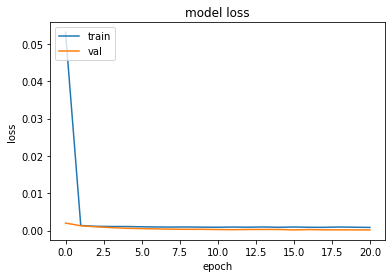

In [ ]:
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

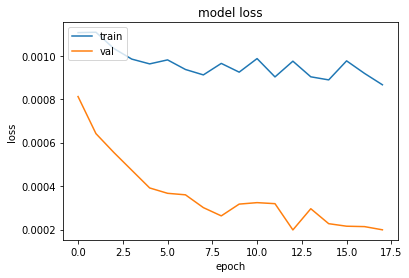

In [ ]:
# summarize history for loss
plt.plot(model_history.history['loss'][3:])
plt.plot(model_history.history['val_loss'][3:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
ts_data_test = ts_data_load.copy()[test_st_data_load:][flist]
ts_data_test[flist] = X_scaler.transform(ts_data_test)
ts_data_test_inputs = TimeSeriesTensor(ts_data_test, "present_storage_tmc", HORIZON, tensor_structure, freq='D')


In [ ]:
ts_data_test_inputs['X'].shape

(691, 30, 7)

In [ ]:
def create_evaluation_df1(predictions, test_inputs, H, scaler):
    """Create a data frame for easy evaluation"""
    eval_df = pd.DataFrame(
        predictions, columns=["t+" + str(t) for t in range(1, H + 1)]
    )
    
    eval_df["timestamp"] = test_inputs.dataframe.index
    print(eval_df.shape, eval_df.head(2))

    #eval_df = pd.melt(
    #    eval_df, id_vars="timestamp", value_name="prediction", var_name="h"
    #)
    values = ['t+'+str(i) for i in range(1, H+1)]
    
    eval_df = pd.melt(
        eval_df, id_vars="timestamp", value_vars=values, value_name="prediction"
    )
    print(eval_df.shape, eval_df.head(2))
    eval_df["actual"] = np.transpose(test_inputs["target"]).ravel()
    eval_df[["prediction", "actual"]] = scaler.inverse_transform(
        eval_df[["prediction", "actual"]]
    )
    return eval_df

In [ ]:
ts_predictions = model.predict(ts_data_test_inputs["X"])

ev_ts_data = create_evaluation_df1(ts_predictions, ts_data_test_inputs, HORIZON, y_scaler)
ev_ts_data.sample(5)

(691, 2)         t+1  timestamp
0  0.231420 2019-05-31
1  0.230692 2019-06-01
(691, 3)    timestamp variable  prediction
0 2019-05-31      t+1    0.231420
1 2019-06-01      t+1    0.230692


,timestamp,variable,prediction,actual
85,2019-08-24,t+1,49.641307,49.450000
137,2019-10-15,t+1,49.288294,49.450000
228,2020-02-14,t+1,38.076829,37.490000
496,2021-01-12,t+1,40.968372,41.471714
600,2021-04-26,t+1,19.293534,18.795727


In [ ]:

mape(ev_ts_data["prediction"], ev_ts_data["actual"])

0.0183621815912172

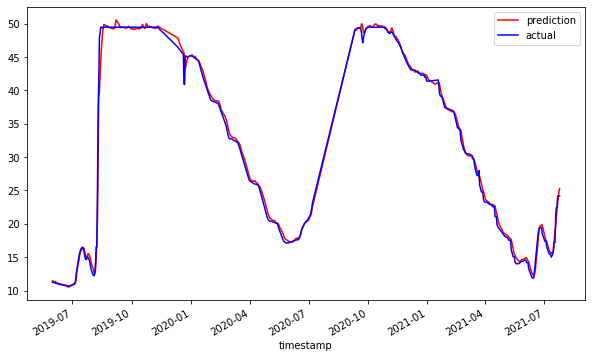

In [ ]:
ev_ts_data[ev_ts_data.variable=='t+1'].plot(
    x="timestamp", y=["prediction", "actual"], style=["r", "b"], figsize=(10, 6)
)

In [ ]:
ev_ts_data.to_csv("forecast_withdatecolumns.csv")

In [ ]:
import datetime
forecast_dates = ev_ts_data.apply(
         lambda row: row.timestamp + datetime.timedelta(days=int(row.variable[2:])),
         axis=1)
ev_ts_data["date"] = forecast_dates


In [ ]:
ev_ts_data.head(2)

,timestamp,variable,prediction,actual,date
0,2019-05-31,t+1,11.575661,11.25,2019-06-01
1,2019-06-01,t+1,11.544778,11.22,2019-06-02


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
#finetuning
T = 30
HORIZON = 1
ftrain = ts_data_load.copy()[flist]

X_scaler = MinMaxScaler()
ftrain[flist] = X_scaler.fit_transform(ftrain)
ftrain.sample(2)

,present_storage_tmc,inflow_tmc,outflow_tmc,max_temp,visibility,humidity,wind
date,,,,,,,
2018-05-01,0.161375,0.000509,0.004625,0.607477,0.176190,0.567940,0.069056
2015-07-18,0.600404,0.012522,0.060291,0.579439,0.180952,0.838279,0.132841


In [ ]:
ftrain.last('1D')

,present_storage_tmc,inflow_tmc,outflow_tmc,max_temp,visibility,humidity,wind
date,,,,,,,
2021-07-25,0.488493,0.053957,0.015142,0.415888,0.483333,0.822377,0.108065


In [ ]:
from datetime import date
date.today()

2021-07-25


In [ ]:
tensor_structure = {"X": (range(-T + 1, 1), flist)}

ts_train_inp = TimeSeriesTensor(
    dataset=ftrain,
    target="present_storage_tmc",
    H=HORIZON,
    tensor_structure=tensor_structure,
    freq="D",
    drop_incomplete=True,
)
#back_ts_data = dt.datetime.strptime(date.today(), "%Y-%m-%d %H:%M:%S") - dt.timedelta(
#    days=T - 1
#)


In [ ]:
model_history = model.fit(
    ts_train_inp["X"],
    ts_train_inp["target"],
    batch_size=BATCH_SIZE,
    epochs=15,
    #validation_data=(valid_inputs["X"], valid_inputs["target"]),
    #callbacks=[earlystop],
    verbose=1,
)

Epoch 1/15
102/102 [==============================] - 3s 27ms/step - loss: 7.3007e-04
Epoch 2/15
102/102 [==============================] - 3s 26ms/step - loss: 6.9745e-04
Epoch 3/15
102/102 [==============================] - 3s 26ms/step - loss: 6.5586e-04
Epoch 4/15
102/102 [==============================] - 3s 26ms/step - loss: 6.6096e-04
Epoch 5/15
102/102 [==============================] - 3s 26ms/step - loss: 6.3898e-04
Epoch 6/15
102/102 [==============================] - 3s 27ms/step - loss: 6.3464e-04
Epoch 7/15
102/102 [==============================] - 3s 26ms/step - loss: 6.2074e-04
Epoch 8/15
102/102 [==============================] - 3s 27ms/step - loss: 6.2640e-04
Epoch 9/15
102/102 [==============================] - 3s 27ms/step - loss: 6.3284e-04
Epoch 10/15
102/102 [==============================] - 3s 26ms/step - loss: 6.2020e-04
Epoch 11/15
102/102 [==============================] - 3s 26ms/step - loss: 6.3409e-04
Epoch 12/15
102/102 [==============================]

In [ ]:
ts_predictions = model.predict(ts_train_inp["X"])

ev_all_data = create_evaluation_df1(ts_predictions, ts_train_inp, HORIZON, y_scaler)
ev_all_data.sample(5)

(3242, 2)         t+1  timestamp
0  0.847011 2011-01-29
1  0.841989 2011-01-30
(3242, 3)    timestamp variable  prediction
0 2011-01-29      t+1    0.847011
1 2011-01-30      t+1    0.841989


,timestamp,variable,prediction,actual
677,2014-02-11,t+1,32.687022,32.220
173,2011-07-21,t+1,32.627236,32.890
1091,2015-06-01,t+1,9.443934,9.250
3230,2021-07-14,t+1,15.618366,15.326
2243,2018-07-27,t+1,47.711795,46.570


In [ ]:

mape(ev_all_data["prediction"], ev_all_data["actual"])

inf

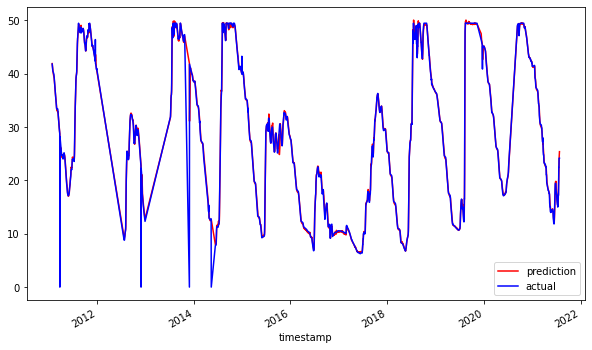

In [ ]:
ev_all_data[ev_all_data.variable=='t+1'].plot(
    x="timestamp", y=["prediction", "actual"], style=["r", "b"], figsize=(10, 6)
)

In [ ]:
cp -r '/content/30daysto1day' '/content/gdrive/My Drive/Wave2web/'

In [ ]:
import datetime
forecast_dates = ev_all_data.apply(
         lambda row: row.timestamp + datetime.timedelta(days=int(row.variable[2:])),
         axis=1)
ev_all_data["date"] = forecast_dates


In [ ]:
ev_all_data.sample(15)

,timestamp,variable,prediction,actual,date
1055,2015-04-26,t+1,15.207088,14.710,2015-04-27
654,2014-01-19,t+1,36.712296,36.210,2014-01-20
1684,2017-01-14,t+1,10.429794,10.520,2017-01-15
1208,2015-09-26,t+1,25.898792,25.130,2015-09-27
1056,2015-04-27,t+1,14.870181,14.350,2015-04-28
2365,2018-11-26,t+1,40.144268,39.940,2018-11-27
3103,2021-03-09,t+1,30.030834,30.318,2021-03-10
1705,2017-02-04,t+1,10.152931,10.340,2017-02-05
2979,2020-11-05,t+1,48.517061,48.600,2020-11-06
2452,2019-02-21,t+1,29.739140,29.430,2019-02-22


In [ ]:
ev_all_data.to_csv("predictions.csv")

In [ ]:
import sqlite3


In [ ]:
conn = sqlite3.connect('predictions.db')
c = conn.cursor()

In [ ]:
df = pd.read_csv("predictions.csv")

In [ ]:
df.head()

,Unnamed: 0,timestamp,variable,prediction,actual,date
0,0,2011-01-29,t+1,41.820400,41.79,2011-01-30
1,1,2011-01-30,t+1,41.589464,41.56,2011-01-31
2,2,2011-01-31,t+1,41.276625,41.30,2011-02-01
3,3,2011-02-01,t+1,41.035273,40.98,2011-02-02
4,4,2011-02-02,t+1,40.736331,40.66,2011-02-03


In [ ]:
c.execute("CREATE TABLE PREDICTIONS ([timestamp] integer, [prediction] integer, [actual] integer, [date] integer)")

In [ ]:
conn.commit()

In [ ]:
conn = sqlite3.connect('predictions.db')  
c = conn.cursor()

In [ ]:
df[['timestamp', 'prediction', 'actual', 'date']].to_sql('PREDICTIONS', conn, if_exists='append', index = False)